## Week 4 Assignment

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00


In [3]:
!pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 38.0 MB/s eta 0:00:00


In [4]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 18.4 MB/s eta 0:00:00


In [5]:
#
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree

import pyproj
import cartopy.crs as ccrs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster

#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp
    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD

In [6]:
path = '/content/drive/MyDrive/GEOL0069/week4/'
SAR_file='S3B_SR_2_LAN_SI_20190301T231304_20190301T233006_20230405T162425_1021_022_301______LN3_R_NT_005.SEN3'
print('overlapping SAR file is',SAR_file)
SAR_data=Dataset(path + SAR_file+'/enhanced_measurement.nc')

SAR_lat, SAR_lon, waves, sig_0, RIP, flag = unpack_gpod('lat_20_ku'), unpack_gpod('lon_20_ku'), unpack_gpod('waveform_20_ku'),unpack_gpod('sig0_water_20_ku'),unpack_gpod('rip_20_ku'),unpack_gpod('surf_type_class_20_ku') #unpack_gpod('Sigma0_20Hz')
SAR_index=np.arange(np.size(SAR_lat))

find=np.where(SAR_lat >= -99999)#60
SAR_lat=SAR_lat[find]
SAR_lon=SAR_lon[find]
SAR_index=SAR_index[find]
waves=waves[find]
sig_0=sig_0[find]
RIP=RIP[find]

PP=peakiness(waves)
SSD=calculate_SSD(RIP)
sig_0_np = np.array(sig_0)  # Replace [...] with your data
RIP_np = np.array(RIP)
PP_np = np.array(PP)
SSD_np = np.array(SSD)

data = np.column_stack((sig_0_np,PP_np, SSD_np))
# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

overlapping SAR file is S3B_SR_2_LAN_SI_20190301T231304_20190301T233006_20230405T162425_1021_022_301______LN3_R_NT_005.SEN3
Running peakiness function...


<ipython-input-5-5cad4369857a>:67: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


In [7]:
nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")
data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)]
flag_cleaned = flag[~np.isnan(data_normalized).any(axis=1)]

Number of NaN values in the array: 387


In [8]:
# gmm = GaussianMixture(n_components=2, random_state=0)
# gmm.fit(data_cleaned)
# clusters_gmm = gmm.predict(data_cleaned)

In [9]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)])
clusters_gmm = gmm.predict(data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)])

In [10]:
waves_cleaned=waves[~np.isnan(data_normalized).any(axis=1)][(flag_cleaned==1)|(flag_cleaned==2)]

In [11]:
clusters_gmm.shape

(6849,)

In [12]:
print(clusters_gmm)

[0 0 0 ... 1 1 1]


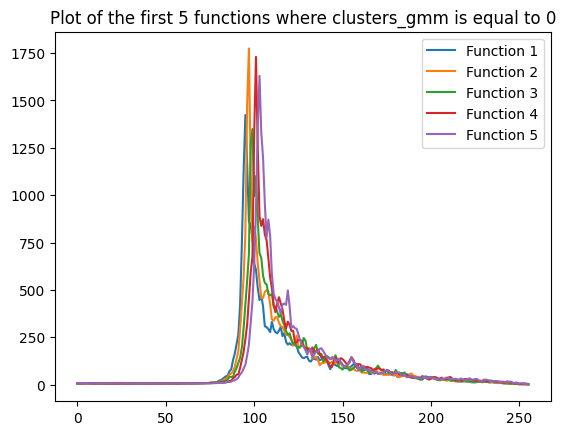

In [13]:
# Extract the first 5 functions where clusters_gmm is equal to 0
functions_to_plot = waves_cleaned[clusters_gmm == 0][:5]

# Plot each function
for i, function in enumerate(functions_to_plot):
    plt.plot(function, label=f'Function {i+1}')

# plt.xlabel('X-axis Label')
# plt.ylabel('Y-axis Label')
plt.title('Plot of the first 5 functions where clusters_gmm is equal to 0')
plt.legend()
plt.show()

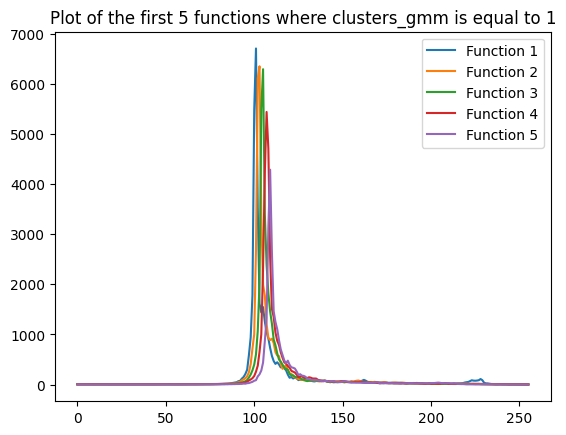

In [14]:
# Extract the first 5 functions where clusters_gmm is equal to 1
functions_to_plot = waves_cleaned[clusters_gmm == 1][:5]

# Plot each function
for i, function in enumerate(functions_to_plot):
    plt.plot(function, label=f'Function {i+1}')

# plt.xlabel('X-axis Label')
# plt.ylabel('Y-axis Label')
plt.title('Plot of the first 5 functions where clusters_gmm is equal to 1')
plt.legend()
plt.show()

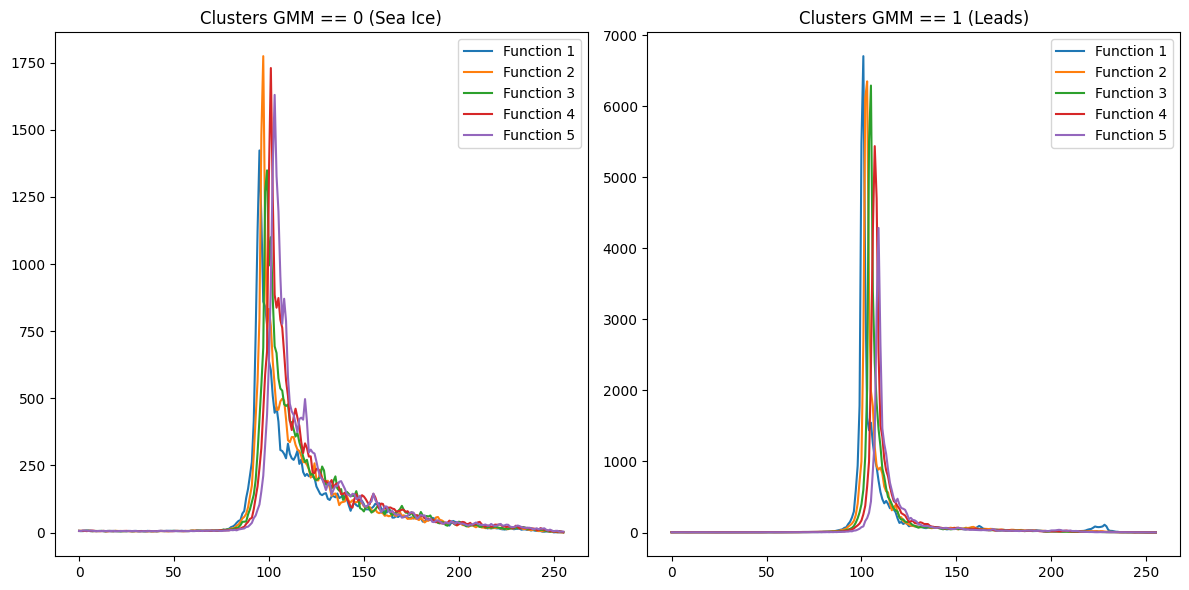

In [15]:
## Show both clusters_gmm equal to 0 and 1 together
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot functions where clusters_gmm is equal to 0
functions_to_plot_0 = waves_cleaned[clusters_gmm == 0][:5]
for i, function in enumerate(functions_to_plot_0):
    axs[0].plot(function, label=f'Function {i+1}')

# Plot functions where clusters_gmm is equal to 1
functions_to_plot_1 = waves_cleaned[clusters_gmm == 1][:5]
for i, function in enumerate(functions_to_plot_1):
    axs[1].plot(function, label=f'Function {i+1}')

# Set titles
axs[0].set_title('Clusters GMM == 0 (Sea Ice)')
axs[1].set_title('Clusters GMM == 1 (Leads)')

# Add legends
axs[0].legend()
axs[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

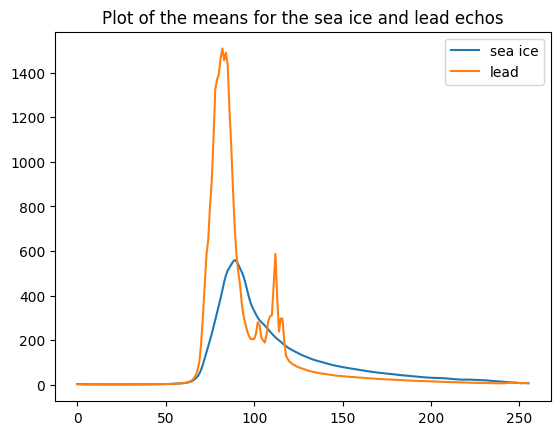

In [16]:
plt.plot(np.mean(waves_cleaned[clusters_gmm==0],axis=0),label='sea ice')
plt.plot(np.mean(waves_cleaned[clusters_gmm==1],axis=0),label='lead')

plt.title('Plot of the means for the sea ice and lead echos')
plt.legend()

In [17]:
#print(np.mean(waves_cleaned[clusters_gmm==0],axis=0),np.mean(waves_cleaned[clusters_gmm==1],axis=0))

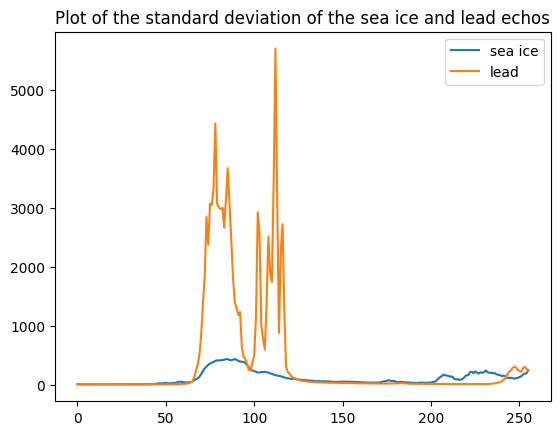

In [18]:
plt.plot(np.std(waves_cleaned[clusters_gmm==0],axis=0),label='sea ice')
plt.plot(np.std(waves_cleaned[clusters_gmm==1],axis=0),label='lead')

plt.title('Plot of the standard deviation of the sea ice and lead echos')
plt.legend()

In [19]:
#print(np.std(waves_cleaned[clusters_gmm==0],axis=0),np.std(waves_cleaned[clusters_gmm==1],axis=0))

In [20]:
unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))

print(class_counts)

{0: 5013, 1: 1836}
